![title](images/header.png)

# Vb - Supervised Classification with CAFI data
-------
this notebook performs a supervised classification of probability of forest change using the merged eSBAE and CEO data trained on the interpreted data from CAFI DDD phase I (2015-2020).  
The change probability is then divided into 3 strata using kmeans
The modeled data are exported to csv for the following script to extract samples for validation in CEO.

This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [106]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1 - CEO data preparation

### 1.1 - Import CEO interpreted data
Import the CEO validated data from CAFI DDD first phase

13,115 points, randomly distributed over CAFI, with interpretation

In [107]:
# this file is available here: https://drive.google.com/file/d/1D1tkVVhKv6QNCQhLLfRo7eqz0VO3XZZF/view?usp=sharing
# unzip and upload to your SEPAL workspace using Filezilla
trn_ceo = pd.read_csv('/home/sepal-user/CAFI_DDD/all_ceo_validation_TMF_2023_uniqueID.csv', delimiter=',')
#trn_ceo = pd.read_csv('/home/sepal-user/data/validation/all_ceo_validation.csv', delimiter=',')
trn_ceo.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_ChDate,Change_Bin,UniqueID
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2018,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2020,1,2
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg_2020,1,3
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,4
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,5


### Load the corresponding augmented data set into a GDF

In [108]:
# this geojson file can be downloaded here: https://drive.google.com/file/d/1fEDJSnHVR8AqmqPKbeOvVtRGvrdieYwm/view?usp=sharing
# unzip and upload to your SEPAL workspace using FileZilla
trn_gdf = py_helpers.geojson_to_gdf('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_1520.geojson')
trn_gdf.columns

Index(['geometry', 'UniqueID', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [109]:
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

In [110]:
len(trn_gdf.index)

13115

In [111]:
len(trn_ceo.index)

13115

In [112]:
trn_gdf = trn_gdf[cols_to_export]

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [113]:
trn_ceo.columns

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_ChDate', 'Change_Bin', 'UniqueID'],
      dtype='object')

In [114]:
trn_ceo['UniqueID'].nunique(dropna=False)

13115

In [115]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [116]:
# show unique values for the columns (in red)
print('Change', trn_ceo['Ref_Change'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [117]:
# add def column for classification
trn_ceo['Def_Bin'] = trn_ceo['Ref_Change'].apply(lambda x: 1 if x == 'Def' else 0)
np.unique(trn_ceo['Def_Bin'], return_counts=True)

(array([0, 1]), array([10574,  2541]))

In [118]:
# add def column for classification
trn_ceo['Deg_Bin'] = trn_ceo['Ref_Change'].apply(lambda x: 1 if x == 'Deg' else 0)
np.unique(trn_ceo['Deg_Bin'], return_counts=True)

(array([0, 1]), array([11816,  1299]))

In [119]:
trn_join = pd.merge(trn_ceo,trn_gdf, left_on='UniqueID', right_on='UniqueID',how='outer')
len(trn_join.index)

13115

In [132]:
trn_join.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,1,6,6,6,6,6,0.0,0.0,70.0,91.0
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,1,6,6,6,6,6,0.0,0.0,70.0,91.0
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,...,2,6,6,6,6,6,0.0,0.0,70.0,91.0
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,...,1,6,6,6,6,6,0.0,0.0,70.0,91.0
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,...,2,6,6,6,6,6,0.0,0.0,70.0,91.0


# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data from script 4
your area must intersect with the CAFI region

In [120]:
# glob all files in the data augmentation output folder
# select path for country of interest
files = Path('/home/sepal-user/module_results/esbae/GAB/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/DRC/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/COG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/EQG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CMR/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CAR/04_Dataset_Augmentation/Landsat/').glob('*geojson')

# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

In [121]:
len(cdf.index)

222878

In [122]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [123]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       

In [126]:
print(trn_ceo.columns)

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_ChDate', 'Change_Bin', 'UniqueID', 'Def_Bin', 'Deg_Bin'],
      dtype='object')


### 2.2 - Make a union with training data

In [127]:
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

In [133]:
harm_cols = eSBAE_cols + ['geometry','point_id','Change_Bin','Def_Bin','Deg_Bin']
#cols_to_harmonize

In [134]:
#cdf['UniqueID'] = 0
cdf['Change_Bin'] = float('nan')
cdf['Def_Bin'] = float('nan')
cdf['Deg_Bin'] = float('nan')
trn_join['point_id']= 0

db = pd.concat([cdf[harm_cols],trn_join[harm_cols]])

In [135]:
len(db.index)

235993

In [136]:
trn_join.head(2)

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,...,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,point_id
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,6,6,6,6,6,0.0,0.0,70.0,91.0,0
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,6,6,6,6,6,0.0,0.0,70.0,91.0,0


In [137]:
db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [138]:
len(cdf.index)+len(trn_join.index) == len(db.index)

True

#### 2.2a - assign 2015 land cover to all points 
this step is an optional step for stratifying forest types 
the land cover classification can be downloaded here: https://drive.google.com/file/d/1St-KuG_x-Hw2_89vu-3Q-lHmBOTSisF1/view?usp=sharing
caution - the land cover map is very large
unzip it and upload to your SEPAL workspace using Filezilla
or use your own layer

In [139]:
src = rasterio.open("/home/sepal-user/data/lc_map/CAFI_LC_2015_19_wgs84.tif")

In [140]:
coord_list = [(x, y) for x, y in zip(db["geometry"].x, db["geometry"].y)]

In [141]:
db["CAFI_LC_2015"] = [x for x in src.sample(coord_list)]
db["CAFI_LC_2015"] = db["CAFI_LC_2015"].str[0]
db.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,...,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,Change_Bin,Def_Bin,Deg_Bin,CAFI_LC_2015
0,29,14,2019.370,-363.350922,-1.312189,2019.370,0.192652,8927.059524,9052.779762,1848.514062,...,0.0,0.0,10.0,10.0,POINT (11.38405 -0.90798),100573,NaN,NaN,NaN,1
1,40,24,2016.285,-993.644531,-11.796512,2018.079,0.317275,3492.458333,9290.569444,463.835893,...,0.0,0.0,10.0,10.0,POINT (12.59379 2.19086),80065,NaN,NaN,NaN,1
2,36,20,2017.751,244.946564,1.024769,2019.899,-0.024154,810.525000,9545.658333,261.241308,...,0.0,0.0,10.0,10.0,POINT (12.60374 2.19087),80589,NaN,NaN,NaN,1
3,34,19,2018.233,-1016.385132,-1.209677,2018.014,0.021870,1256.236842,9479.622807,266.914960,...,0.0,0.0,10.0,10.0,POINT (12.58383 2.19086),79542,NaN,NaN,NaN,1
4,38,18,-1.000,0.000000,0.000000,2020.159,0.344717,1808.333333,9760.111111,264.295167,...,0.0,0.0,10.0,10.0,POINT (10.77810 -1.19751),76053,NaN,NaN,NaN,1


In [142]:
print(db.columns)

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [143]:
db['CAFI_LC_2015'].value_counts(dropna=False)

CAFI_LC_2015
1     188617
13     18020
3       8228
8       5620
18      3198
15      2245
7       2107
4       1534
17      1460
12      1173
19       631
11       594
6        573
14       513
5        485
2        447
16       280
9        259
0          9
Name: count, dtype: int64

### 2.3 Check the amount of ground truth data we have for each class

In [144]:
np.unique(db['Change_Bin'], return_counts=True)

(array([ 0.,  1., nan]), array([  9275,   3840, 222878]))

In [145]:
np.unique(db['Def_Bin'], return_counts=True)

(array([ 0.,  1., nan]), array([ 10574,   2541, 222878]))

In [146]:
np.unique(db['Deg_Bin'], return_counts=True)

(array([ 0.,  1., nan]), array([ 11816,   1299, 222878]))

### Run change/no-change classification

In [147]:
# predictors used change/nochange classification
db['chg_prob'] = clf.binary_probability_classification(db, 'Change_Bin', eSBAE_cols, outlier=False)

OOB Score is 0.7876477316050324


In [148]:
# predictors used change/nochange classification
db['def_prob'] = clf.binary_probability_classification(db, 'Def_Bin', eSBAE_cols, outlier=False)

OOB Score is 0.7558520777735418


In [149]:
# predictors used change/nochange classification
db['deg_prob'] = clf.binary_probability_classification(db, 'Deg_Bin', eSBAE_cols, outlier=False)

OOB Score is 0.6883720930232559


In [150]:
clf_db = db[db["point_id"] > 0]

#### plot the change probability
a good model will have many points with low probability of change, and then very few points with higher probabilites

array([<Axes: title={'center': 'chg_prob'}>], dtype=object)

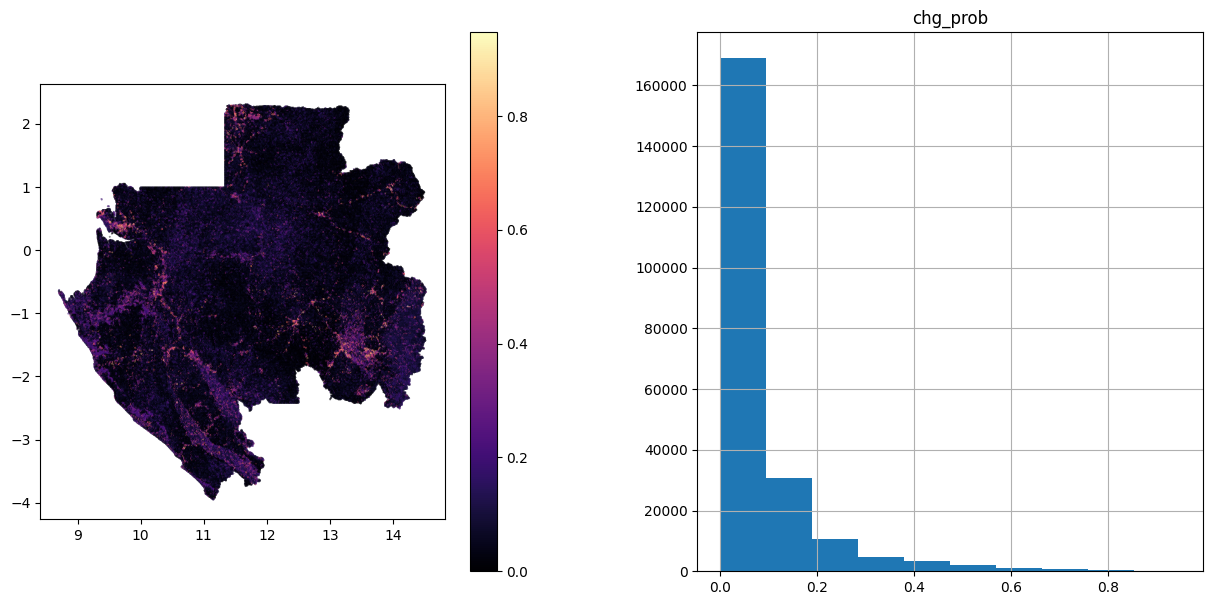

In [39]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob', ax=ax[1])

array([<Axes: title={'center': 'def_prob'}>], dtype=object)

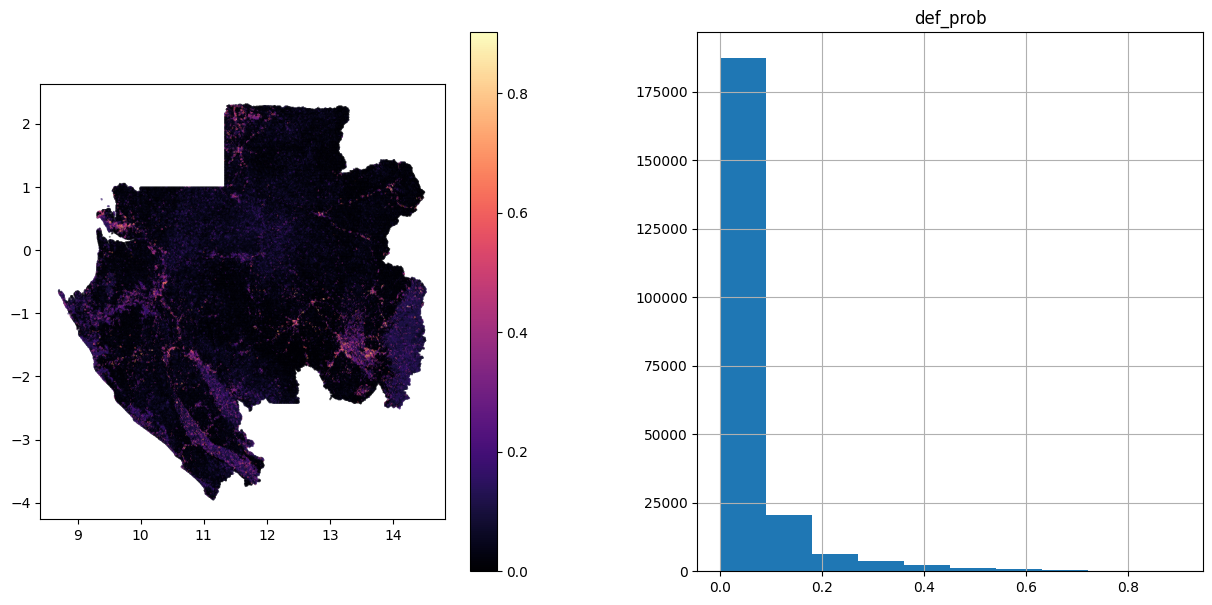

In [151]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('def_prob', ax=ax[1])

array([<Axes: title={'center': 'deg_prob'}>], dtype=object)

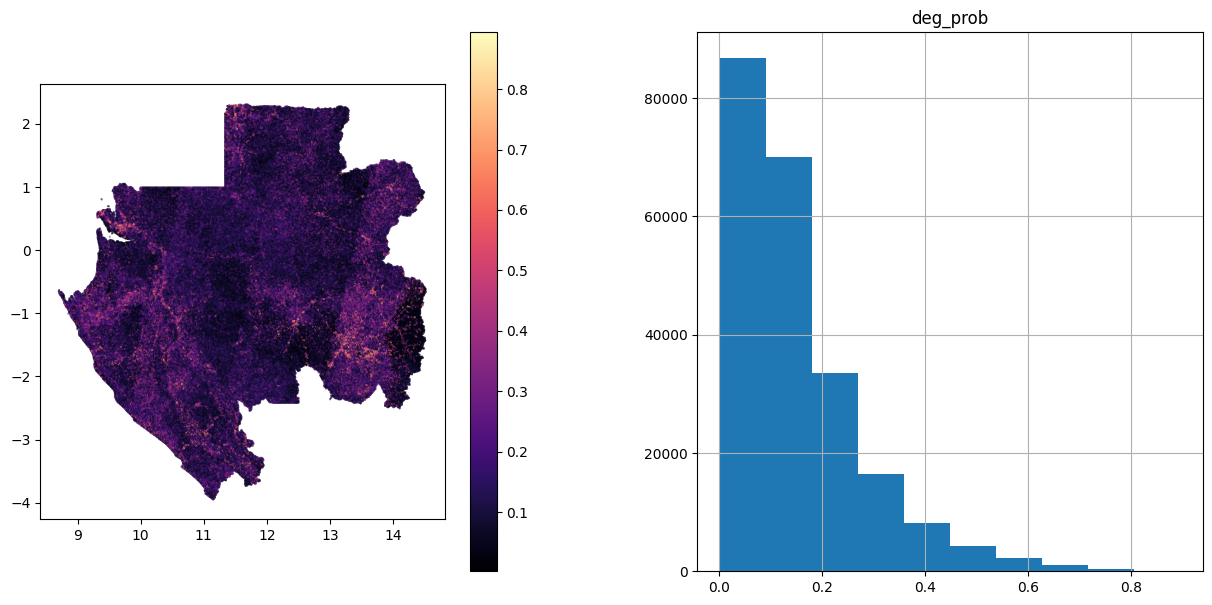

In [152]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('deg_prob', ax=ax[1])

In [153]:
clf_db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [154]:
joined_df = clf_db

In [155]:
joined_df['simple_combined'] = joined_df['chg_prob']

In [156]:
len(joined_df)

222878

In [157]:
joined_df

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,...,geometry,point_id,Change_Bin,Def_Bin,Deg_Bin,CAFI_LC_2015,chg_prob,def_prob,deg_prob,simple_combined
0,29,14,2019.370,-363.350922,-1.312189,2019.370,0.192652,8927.059524,9052.779762,1848.514062,...,POINT (11.38405 -0.90798),100573,NaN,NaN,NaN,1,0.088000,0.064667,0.100000,0.088000
1,40,24,2016.285,-993.644531,-11.796512,2018.079,0.317275,3492.458333,9290.569444,463.835893,...,POINT (12.59379 2.19086),80065,NaN,NaN,NaN,1,0.161333,0.102667,0.171333,0.161333
2,36,20,2017.751,244.946564,1.024769,2019.899,-0.024154,810.525000,9545.658333,261.241308,...,POINT (12.60374 2.19087),80589,NaN,NaN,NaN,1,0.029333,0.023333,0.072000,0.029333
3,34,19,2018.233,-1016.385132,-1.209677,2018.014,0.021870,1256.236842,9479.622807,266.914960,...,POINT (12.58383 2.19086),79542,NaN,NaN,NaN,1,0.032000,0.016000,0.068000,0.032000
4,38,18,-1.000,0.000000,0.000000,2020.159,0.344717,1808.333333,9760.111111,264.295167,...,POINT (10.77810 -1.19751),76053,NaN,NaN,NaN,1,0.019333,0.014000,0.071333,0.019333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,60,34,2016.263,-145.985916,-1.329336,2016.219,-0.008282,1142.202941,9832.644118,184.484986,...,POINT (12.50194 -1.28448),169576,NaN,NaN,NaN,1,0.002000,0.004667,0.024667,0.002000
24996,83,46,2017.071,231.606888,1.566950,2017.532,-0.002234,1056.006884,9797.980797,249.040385,...,POINT (12.50199 -1.30378),170075,NaN,NaN,NaN,1,0.002667,0.002000,0.038667,0.002667
24997,80,45,2016.263,-534.947083,-2.276673,2016.197,0.485412,8280.537037,9639.081481,575.392257,...,POINT (12.50190 -1.26518),169074,NaN,NaN,NaN,1,0.165333,0.064667,0.216667,0.165333
24998,77,44,2016.263,-97.475761,-0.901330,2019.219,0.212770,3704.936364,9724.206061,387.874009,...,POINT (12.49201 -1.28448),169072,NaN,NaN,NaN,3,0.418000,0.268667,0.558000,0.418000


### Stratify with Kmeans

In [165]:
sample_size_no = 10000

In [166]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob', strata=3, sample_size=sample_size_no)

In [167]:
joined_df['kmeans_chg'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,178038,0.038301,0.028722,5113.547068,1,6066,7988
1,35486,0.183077,0.060200,2136.267539,2,2534,1592
2,9354,0.492371,0.126087,1179.417580,3,1399,419


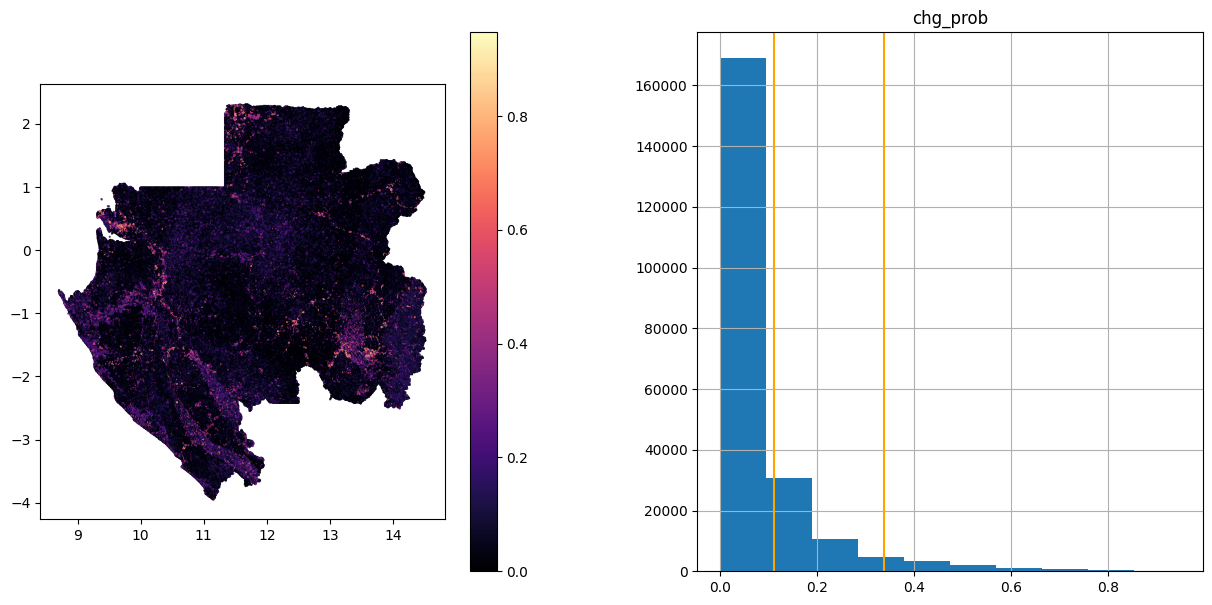

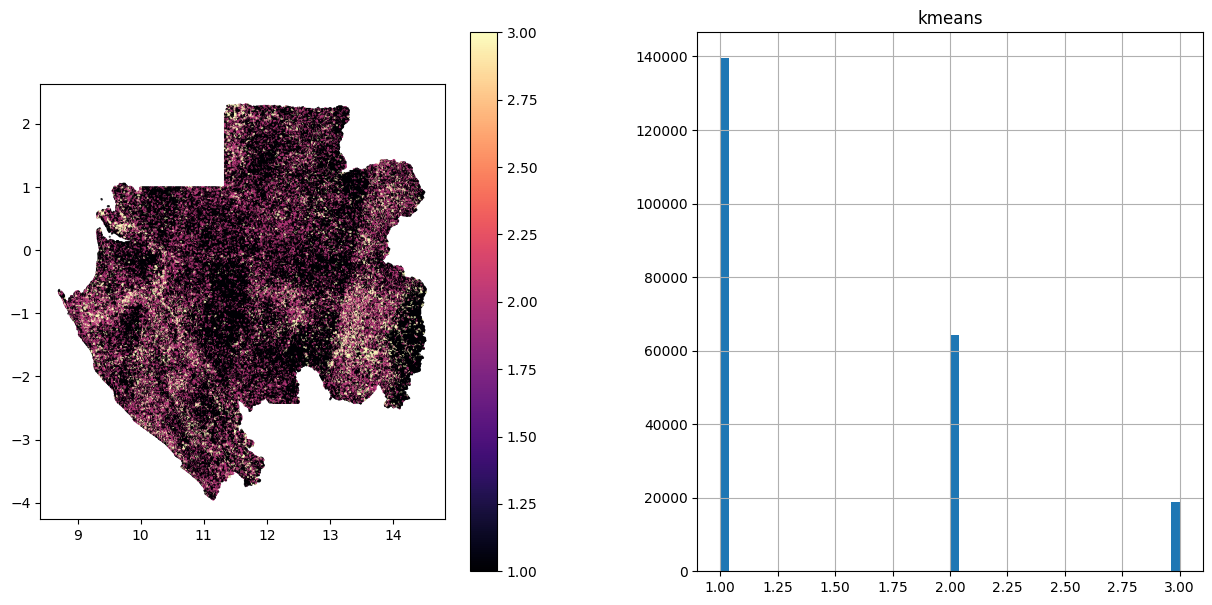

In [168]:
h.plot_cluster(joined_df, prob_column='chg_prob', strata_column='kmeans_chg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans', ax=ax[1], bins=50)
samples

In [169]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'def_prob', strata=3, sample_size=sample_size_no)

In [170]:
joined_df['kmeans_def'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,185060,0.023238,0.020326,3761.456122,1,6047,8303
1,29798,0.146120,0.051505,1534.755844,2,2467,1336
2,8020,0.423270,0.115141,923.430763,3,1484,359


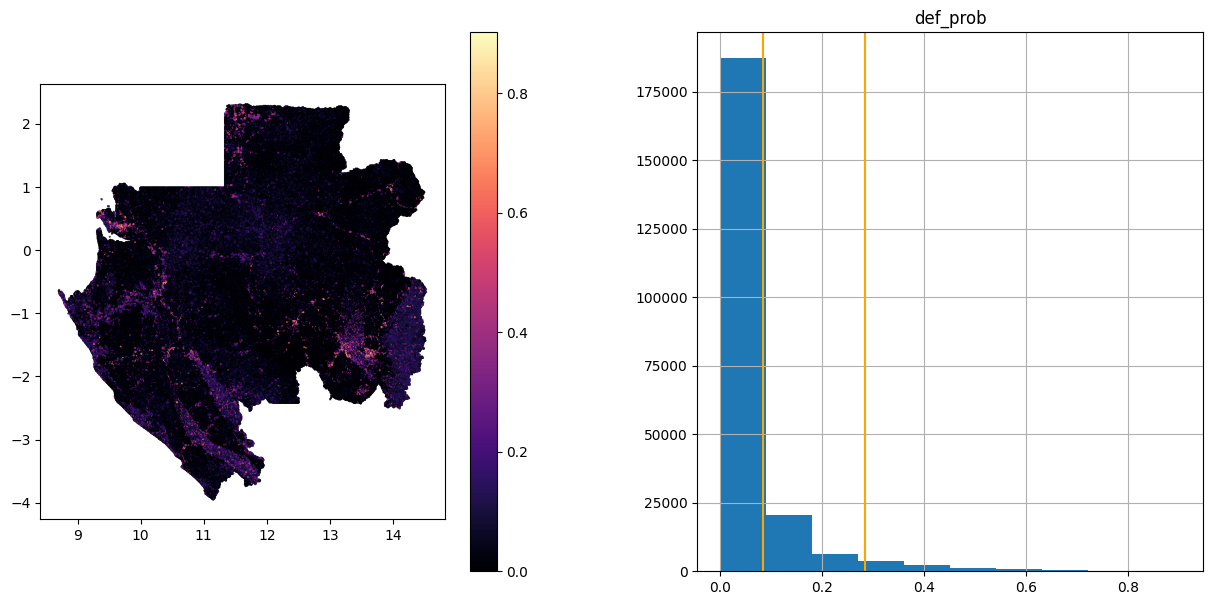

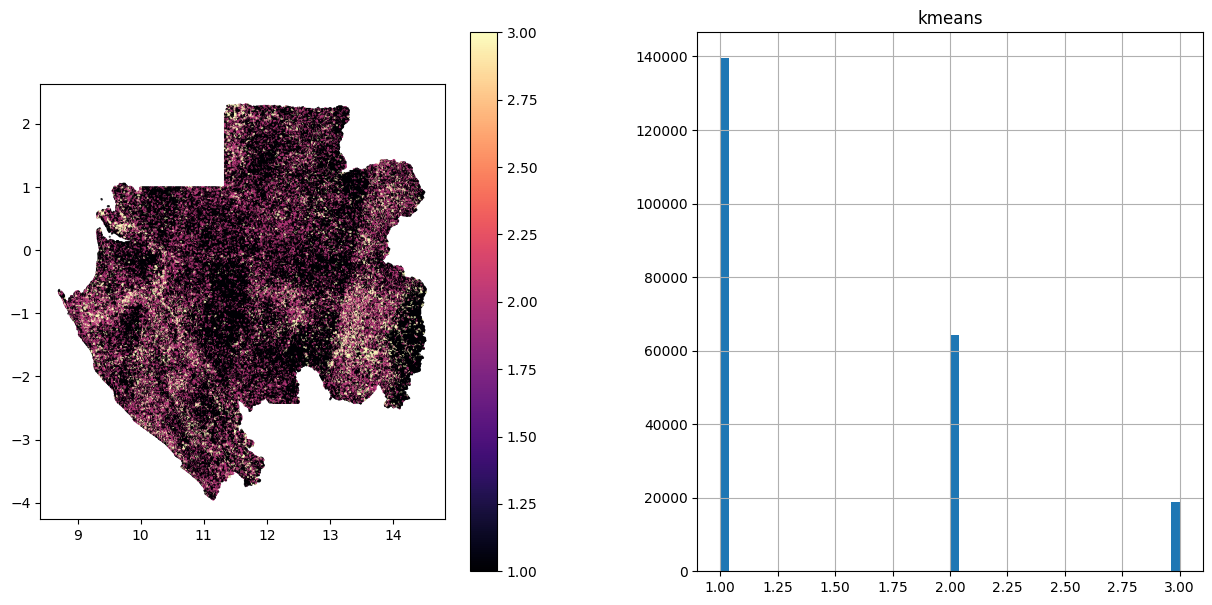

In [171]:
h.plot_cluster(joined_df, prob_column='def_prob', strata_column='kmeans_def')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans', ax=ax[1], bins=50)
samples

In [172]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'deg_prob', strata=3, sample_size=sample_size_no)

In [173]:
joined_df['kmeans_deg'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,139607,0.079758,0.035760,4992.367178,1,4867,6263
1,64332,0.222480,0.051256,3297.388054,2,3215,2886
2,18939,0.456870,0.103823,1966.303544,3,1917,849


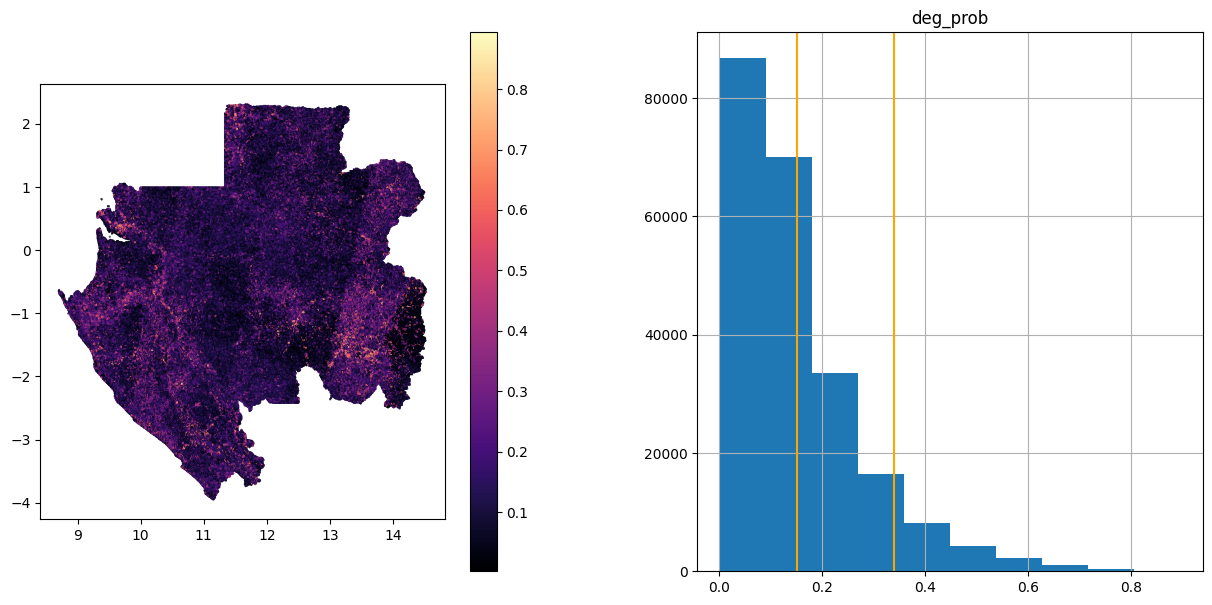

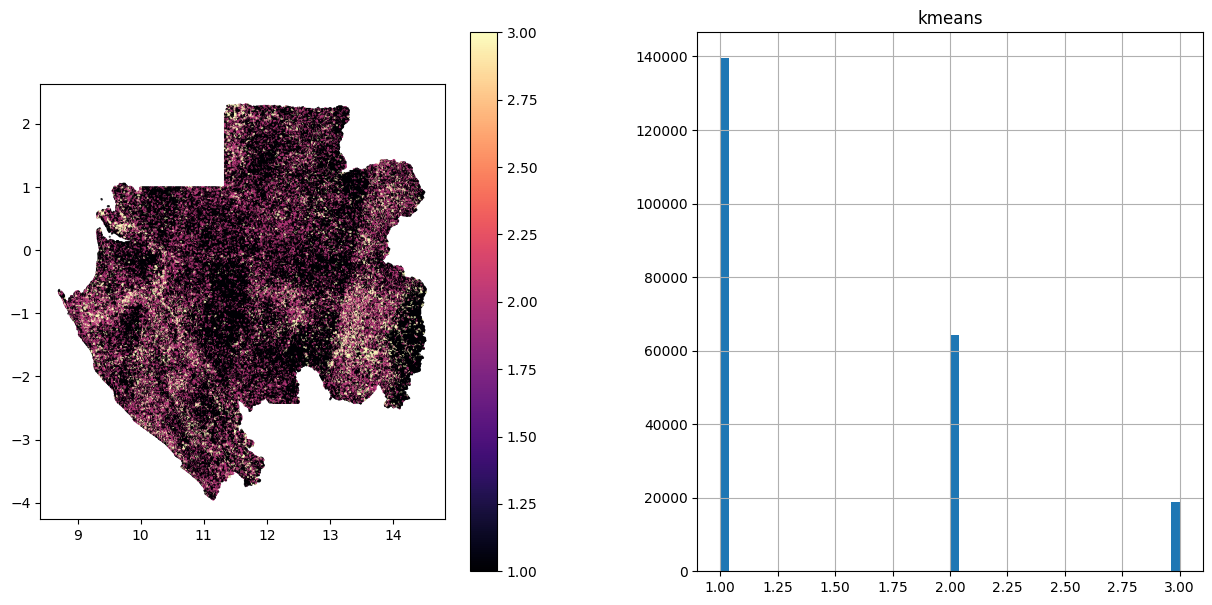

In [174]:
h.plot_cluster(joined_df, prob_column='deg_prob', strata_column='kmeans_deg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans', ax=ax[1], bins=50)
samples

In [177]:
cross_tab = pd.crosstab(index= joined_df['kmeans_def'], columns=joined_df['kmeans_deg'], margins=True, margins_name="Total")
cross_tab

kmeans_deg,1,2,3,Total
kmeans_def,,,,
1,126605,50178,8277,185060
2,12917,12073,4808,29798
3,85,2081,5854,8020
Total,139607,64332,18939,222878


### align column names, get coordinates


In [178]:
joined_df['PLOTID'] = joined_df['point_id']

In [179]:
joined_df.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd',
       ...
       'chg_prob', 'def_prob', 'deg_prob', 'simple_combined', 'stratum',
       'kmeans', 'kmeans_chg', 'kmeans_def', 'kmeans_deg', 'PLOTID'],
      dtype='object', length=101)

In [180]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

#### export the points for your area with the change probability model

In [181]:
all_points_out_file =  '/home/sepal-user/module_results/esbae/GAB/GAB_esbae_1520_model.csv'
#all_points_out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_1520_model.csv'
#all_points_out_file =  '/home/sepal-user/module_results/esbae/COG/GAB_esbae_1520_model.csv'
#all_points_out_file =  '/home/sepal-user/module_results/esbae/EQG/GAB_esbae_1520_model.csv'
#all_points_out_file =  '/home/sepal-user/module_results/esbae/CMR/GAB_esbae_1520_model.csv'
#all_points_out_file =  '/home/sepal-user/module_results/esbae/CAR/GAB_esbae_1520_model.csv'
joined_df.to_csv(all_points_out_file,index=False)

### now you may proceed to script 5c if you want to extract sample points for CEO